In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pickle
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                             precision_score, recall_score, f1_score)

# Models
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import NearestCentroid
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier


In [2]:
crop = pd.read_csv("Crop_recommendation.csv")
crop.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [3]:
crop.shape

(2200, 8)

In [4]:
crop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [5]:
crop.isnull().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

In [6]:
crop.duplicated().sum()

0

In [7]:
crop.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


In [8]:
crop['label'].value_counts()

label
rice           100
maize          100
jute           100
cotton         100
coconut        100
papaya         100
orange         100
apple          100
muskmelon      100
watermelon     100
grapes         100
mango          100
banana         100
pomegranate    100
lentil         100
blackgram      100
mungbean       100
mothbeans      100
pigeonpeas     100
kidneybeans    100
chickpea       100
coffee         100
Name: count, dtype: int64

In [9]:
crop

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee


In [10]:
warnings.filterwarnings('ignore')
sns.set_style("whitegrid", {'axes.grid' : False})

In [11]:
# Spot-Check Models (New Models)
def GetModel():
    Models = []
    Models.append(('GBM', GradientBoostingClassifier()))
    Models.append(('CatBoost', CatBoostClassifier(silent=True)))
    Models.append(('LDA', LinearDiscriminantAnalysis()))
    Models.append(('QDA', QuadraticDiscriminantAnalysis()))
    Models.append(('NC', NearestCentroid()))
    Models.append(('DecisionTree', DecisionTreeClassifier()))
    Models.append(('SVM', SVC()))
    Models.append(('NaiveBayes', GaussianNB()))
    Models.append(('RandomForest', RandomForestClassifier()))
    return Models

# Performance Measure
def classification_metrics(model, conf_matrix, X_train, y_train, X_test, y_test, y_pred):
    print(f"Training Accuracy Score: {model.score(X_train, y_train) * 100:.1f}%")
    print(f"Validation Accuracy Score: {model.score(X_test, y_test) * 100:.1f}%")
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(conf_matrix), annot=True, cmap='YlGnBu', fmt='g')
    ax.xaxis.set_label_position('top')
    plt.tight_layout()
    plt.title('Confusion Matrix', fontsize=20, y=1.1)
    plt.ylabel('Actual label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    plt.show()
    print(classification_report(y_test, y_pred))

# Save Trained Model
def save_model(model, filename):
    pickle.dump(model, open(filename, 'wb'))


In [12]:
# Load Dataset
df = pd.read_csv('Crop_recommendation.csv')

In [13]:
# Remove Outliers (Only apply to numeric columns)
numeric_cols = df.select_dtypes(include=[np.number]).columns  # Select only numeric columns

Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

df_out = df[~((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]


In [14]:
# Split Data to Training and Validation set
target = 'label'
X_train, X_test, y_train, y_test = train_test_split(df_out.drop(target, axis=1), df_out[target], test_size=0.2, random_state=0)



Training and Evaluating Model: GBM
Training Accuracy Score: 100.0%
Validation Accuracy Score: 98.9%


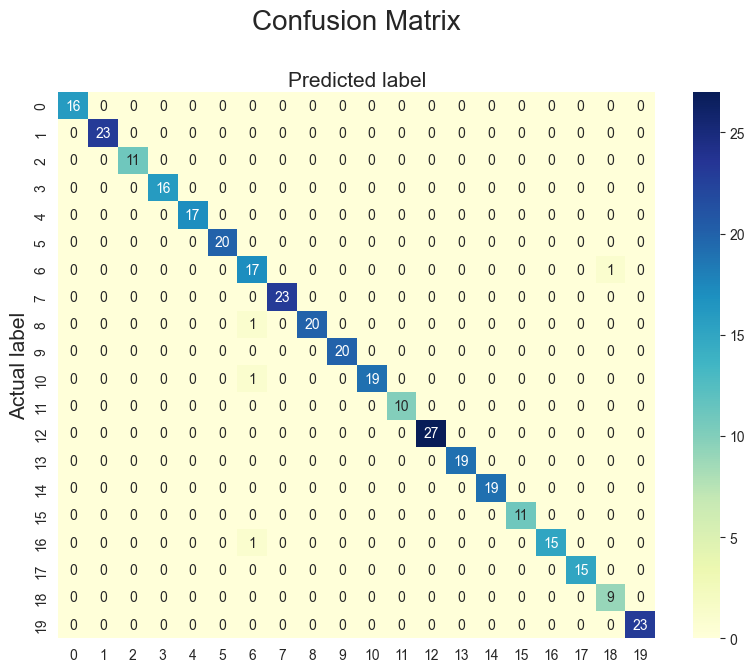

              precision    recall  f1-score   support

      banana       1.00      1.00      1.00        16
   blackgram       1.00      1.00      1.00        23
    chickpea       1.00      1.00      1.00        11
     coconut       1.00      1.00      1.00        16
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        20
        jute       0.85      0.94      0.89        18
 kidneybeans       1.00      1.00      1.00        23
      lentil       1.00      0.95      0.98        21
       maize       1.00      1.00      1.00        20
       mango       1.00      0.95      0.97        20
   mothbeans       1.00      1.00      1.00        10
    mungbean       1.00      1.00      1.00        27
   muskmelon       1.00      1.00      1.00        19
      orange       1.00      1.00      1.00        19
      papaya       1.00      1.00      1.00        11
  pigeonpeas       1.00      0.94      0.97        16
 pomegranate       1.00    

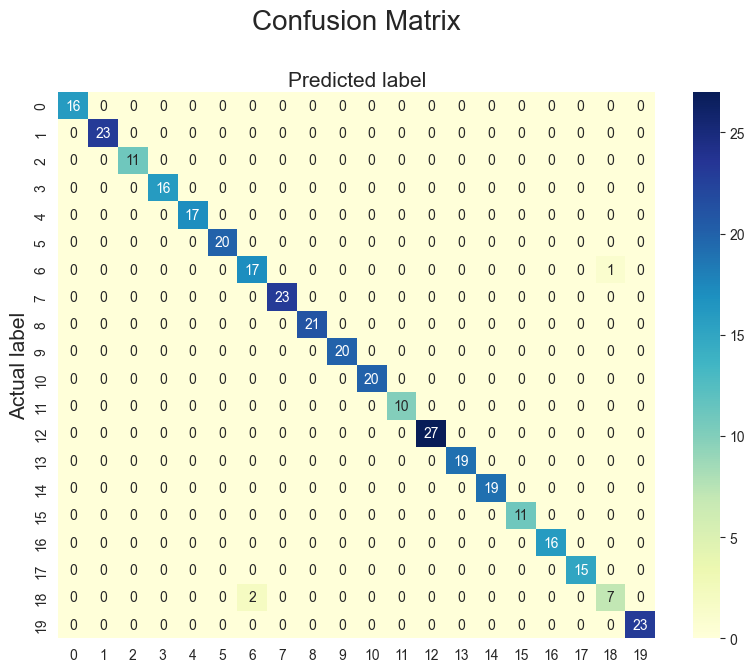

              precision    recall  f1-score   support

      banana       1.00      1.00      1.00        16
   blackgram       1.00      1.00      1.00        23
    chickpea       1.00      1.00      1.00        11
     coconut       1.00      1.00      1.00        16
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        20
        jute       0.89      0.94      0.92        18
 kidneybeans       1.00      1.00      1.00        23
      lentil       1.00      1.00      1.00        21
       maize       1.00      1.00      1.00        20
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      1.00      1.00        10
    mungbean       1.00      1.00      1.00        27
   muskmelon       1.00      1.00      1.00        19
      orange       1.00      1.00      1.00        19
      papaya       1.00      1.00      1.00        11
  pigeonpeas       1.00      1.00      1.00        16
 pomegranate       1.00    

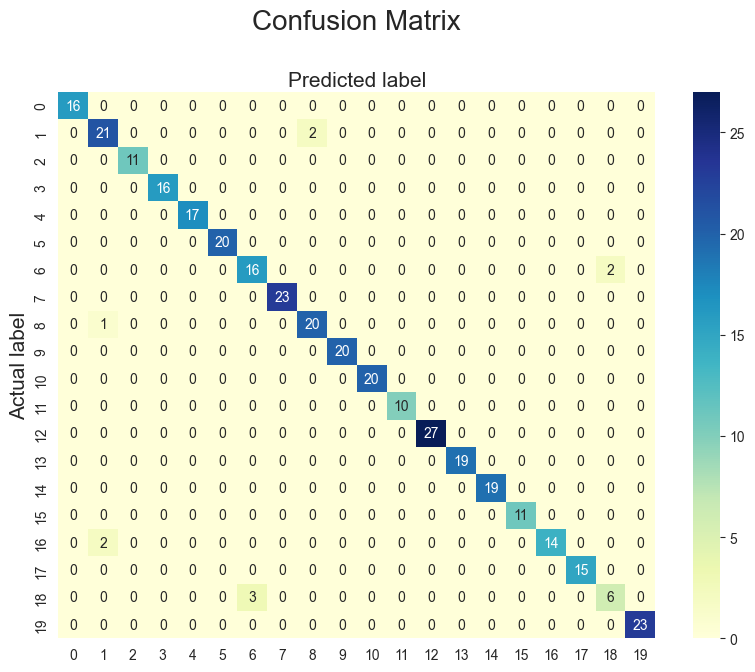

              precision    recall  f1-score   support

      banana       1.00      1.00      1.00        16
   blackgram       0.88      0.91      0.89        23
    chickpea       1.00      1.00      1.00        11
     coconut       1.00      1.00      1.00        16
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        20
        jute       0.84      0.89      0.86        18
 kidneybeans       1.00      1.00      1.00        23
      lentil       0.91      0.95      0.93        21
       maize       1.00      1.00      1.00        20
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      1.00      1.00        10
    mungbean       1.00      1.00      1.00        27
   muskmelon       1.00      1.00      1.00        19
      orange       1.00      1.00      1.00        19
      papaya       1.00      1.00      1.00        11
  pigeonpeas       1.00      0.88      0.93        16
 pomegranate       1.00    

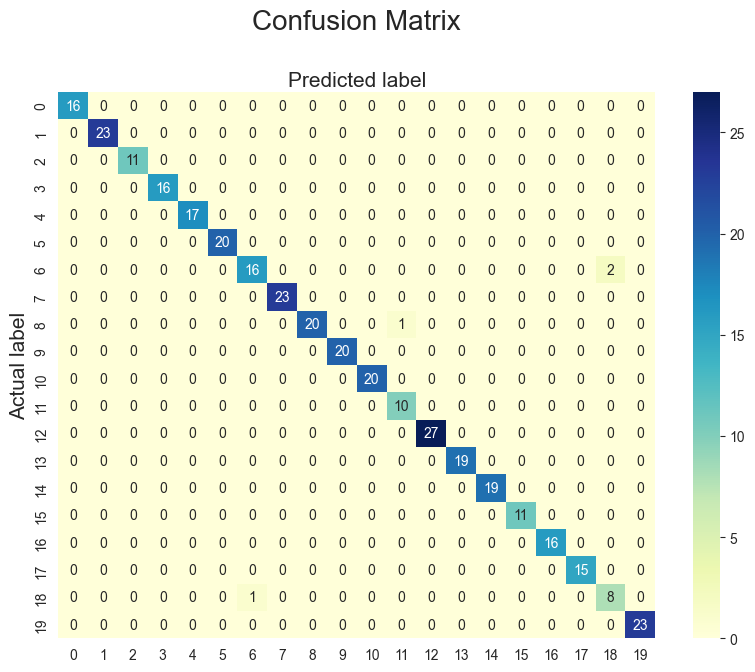

              precision    recall  f1-score   support

      banana       1.00      1.00      1.00        16
   blackgram       1.00      1.00      1.00        23
    chickpea       1.00      1.00      1.00        11
     coconut       1.00      1.00      1.00        16
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        20
        jute       0.94      0.89      0.91        18
 kidneybeans       1.00      1.00      1.00        23
      lentil       1.00      0.95      0.98        21
       maize       1.00      1.00      1.00        20
       mango       1.00      1.00      1.00        20
   mothbeans       0.91      1.00      0.95        10
    mungbean       1.00      1.00      1.00        27
   muskmelon       1.00      1.00      1.00        19
      orange       1.00      1.00      1.00        19
      papaya       1.00      1.00      1.00        11
  pigeonpeas       1.00      1.00      1.00        16
 pomegranate       1.00    

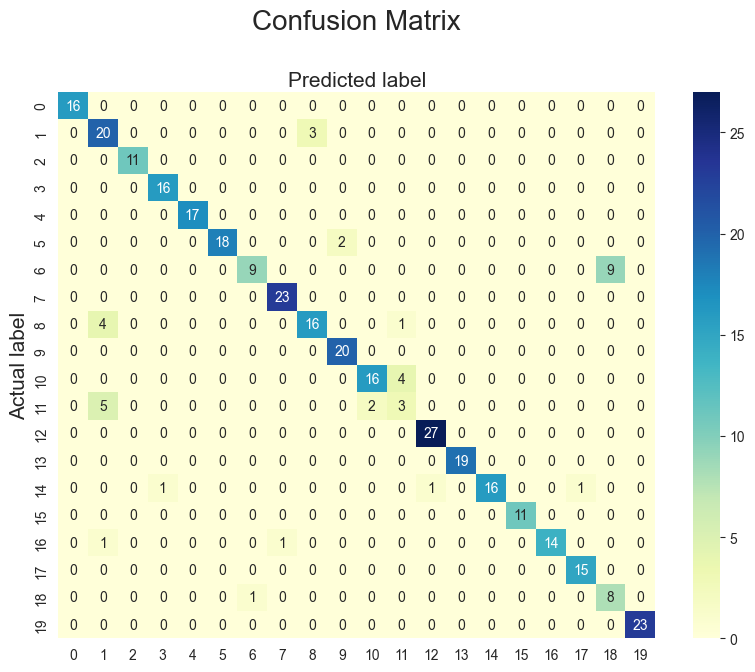

              precision    recall  f1-score   support

      banana       1.00      1.00      1.00        16
   blackgram       0.67      0.87      0.75        23
    chickpea       1.00      1.00      1.00        11
     coconut       0.94      1.00      0.97        16
      coffee       1.00      1.00      1.00        17
      cotton       1.00      0.90      0.95        20
        jute       0.90      0.50      0.64        18
 kidneybeans       0.96      1.00      0.98        23
      lentil       0.84      0.76      0.80        21
       maize       0.91      1.00      0.95        20
       mango       0.89      0.80      0.84        20
   mothbeans       0.38      0.30      0.33        10
    mungbean       0.96      1.00      0.98        27
   muskmelon       1.00      1.00      1.00        19
      orange       1.00      0.84      0.91        19
      papaya       1.00      1.00      1.00        11
  pigeonpeas       1.00      0.88      0.93        16
 pomegranate       0.94    

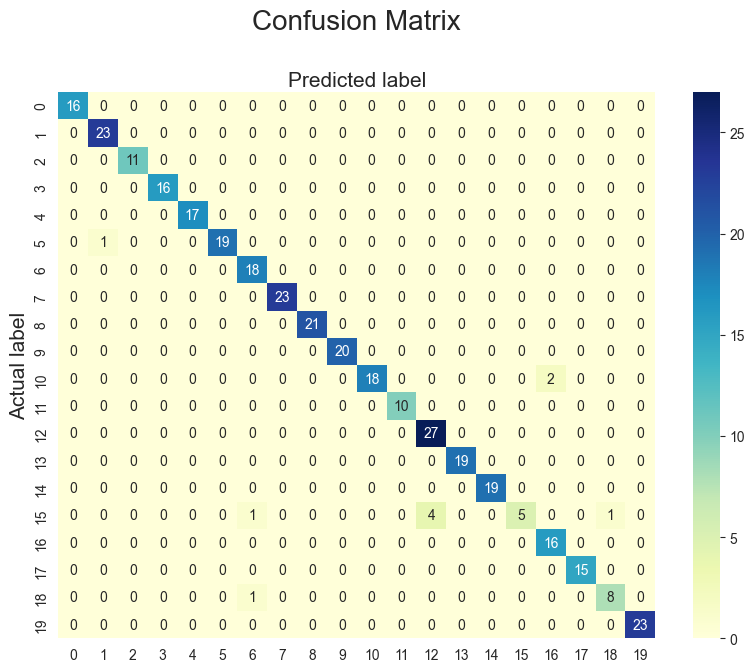

              precision    recall  f1-score   support

      banana       1.00      1.00      1.00        16
   blackgram       0.96      1.00      0.98        23
    chickpea       1.00      1.00      1.00        11
     coconut       1.00      1.00      1.00        16
      coffee       1.00      1.00      1.00        17
      cotton       1.00      0.95      0.97        20
        jute       0.90      1.00      0.95        18
 kidneybeans       1.00      1.00      1.00        23
      lentil       1.00      1.00      1.00        21
       maize       1.00      1.00      1.00        20
       mango       1.00      0.90      0.95        20
   mothbeans       1.00      1.00      1.00        10
    mungbean       0.87      1.00      0.93        27
   muskmelon       1.00      1.00      1.00        19
      orange       1.00      1.00      1.00        19
      papaya       1.00      0.45      0.62        11
  pigeonpeas       0.89      1.00      0.94        16
 pomegranate       1.00    

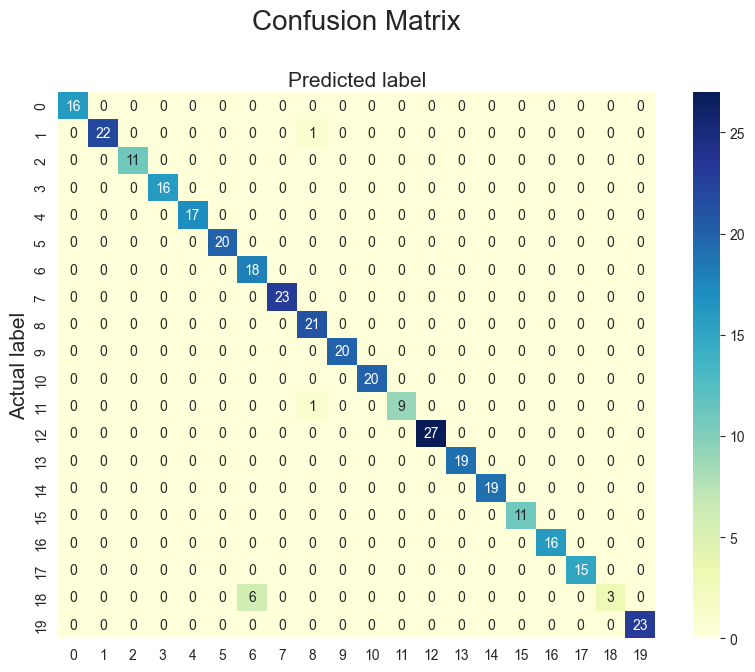

              precision    recall  f1-score   support

      banana       1.00      1.00      1.00        16
   blackgram       1.00      0.96      0.98        23
    chickpea       1.00      1.00      1.00        11
     coconut       1.00      1.00      1.00        16
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        20
        jute       0.75      1.00      0.86        18
 kidneybeans       1.00      1.00      1.00        23
      lentil       0.91      1.00      0.95        21
       maize       1.00      1.00      1.00        20
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      0.90      0.95        10
    mungbean       1.00      1.00      1.00        27
   muskmelon       1.00      1.00      1.00        19
      orange       1.00      1.00      1.00        19
      papaya       1.00      1.00      1.00        11
  pigeonpeas       1.00      1.00      1.00        16
 pomegranate       1.00    

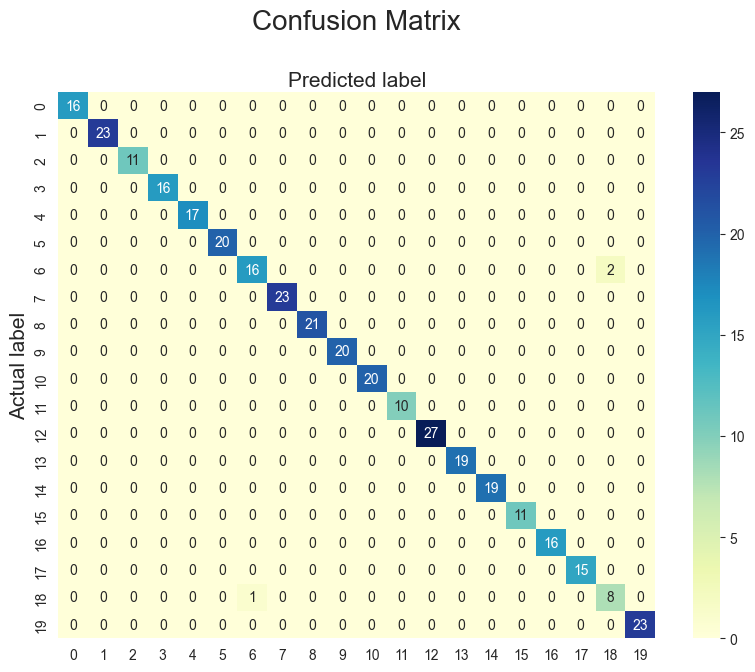

              precision    recall  f1-score   support

      banana       1.00      1.00      1.00        16
   blackgram       1.00      1.00      1.00        23
    chickpea       1.00      1.00      1.00        11
     coconut       1.00      1.00      1.00        16
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        20
        jute       0.94      0.89      0.91        18
 kidneybeans       1.00      1.00      1.00        23
      lentil       1.00      1.00      1.00        21
       maize       1.00      1.00      1.00        20
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      1.00      1.00        10
    mungbean       1.00      1.00      1.00        27
   muskmelon       1.00      1.00      1.00        19
      orange       1.00      1.00      1.00        19
      papaya       1.00      1.00      1.00        11
  pigeonpeas       1.00      1.00      1.00        16
 pomegranate       1.00    

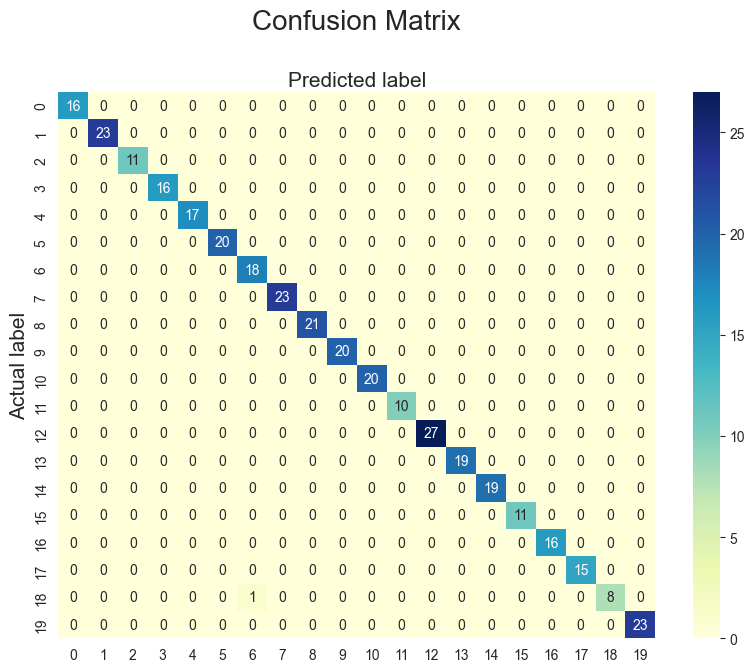

              precision    recall  f1-score   support

      banana       1.00      1.00      1.00        16
   blackgram       1.00      1.00      1.00        23
    chickpea       1.00      1.00      1.00        11
     coconut       1.00      1.00      1.00        16
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        20
        jute       0.95      1.00      0.97        18
 kidneybeans       1.00      1.00      1.00        23
      lentil       1.00      1.00      1.00        21
       maize       1.00      1.00      1.00        20
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      1.00      1.00        10
    mungbean       1.00      1.00      1.00        27
   muskmelon       1.00      1.00      1.00        19
      orange       1.00      1.00      1.00        19
      papaya       1.00      1.00      1.00        11
  pigeonpeas       1.00      1.00      1.00        16
 pomegranate       1.00    

In [15]:
# Train and evaluate all models
models = GetModel()

for name, model in models:
    print(f"\nTraining and Evaluating Model: {name}")
    pipeline = make_pipeline(StandardScaler(), model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Evaluate performance
    classification_metrics(pipeline, conf_matrix, X_train, y_train, X_test, y_test, y_pred)
    
    # Save each model
    save_model(pipeline, f'new_model/{name}_model.pkl')


**Training And Evaluation**


Training and Evaluating Model: GBM
Training Accuracy Score: 100.0%
Validation Accuracy Score: 98.9%
Precision: 0.990
Recall: 0.989
F1 Score: 0.989


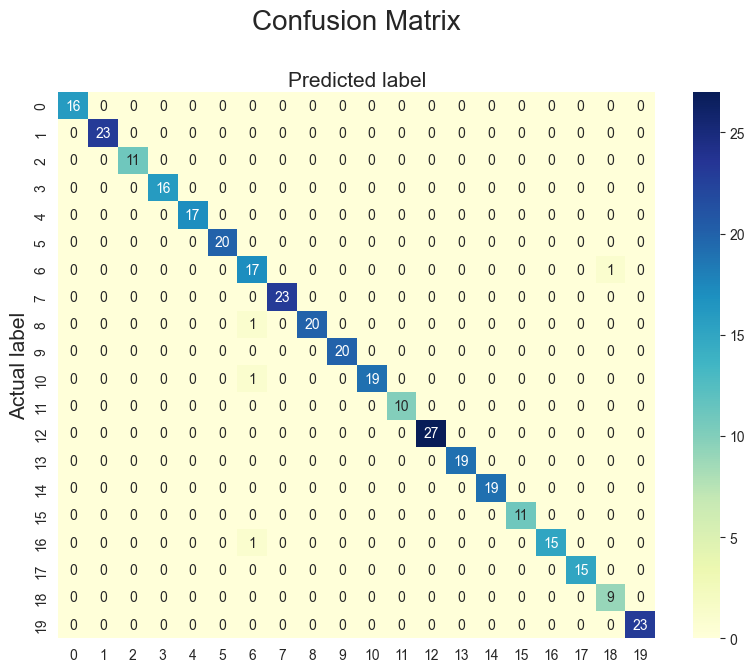

              precision    recall  f1-score   support

      banana       1.00      1.00      1.00        16
   blackgram       1.00      1.00      1.00        23
    chickpea       1.00      1.00      1.00        11
     coconut       1.00      1.00      1.00        16
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        20
        jute       0.85      0.94      0.89        18
 kidneybeans       1.00      1.00      1.00        23
      lentil       1.00      0.95      0.98        21
       maize       1.00      1.00      1.00        20
       mango       1.00      0.95      0.97        20
   mothbeans       1.00      1.00      1.00        10
    mungbean       1.00      1.00      1.00        27
   muskmelon       1.00      1.00      1.00        19
      orange       1.00      1.00      1.00        19
      papaya       1.00      1.00      1.00        11
  pigeonpeas       1.00      0.94      0.97        16
 pomegranate       1.00    

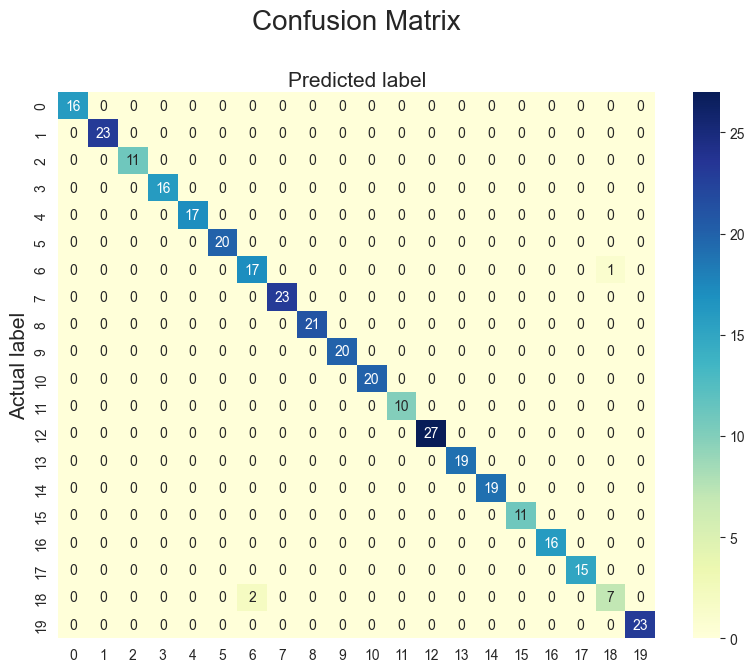

              precision    recall  f1-score   support

      banana       1.00      1.00      1.00        16
   blackgram       1.00      1.00      1.00        23
    chickpea       1.00      1.00      1.00        11
     coconut       1.00      1.00      1.00        16
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        20
        jute       0.89      0.94      0.92        18
 kidneybeans       1.00      1.00      1.00        23
      lentil       1.00      1.00      1.00        21
       maize       1.00      1.00      1.00        20
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      1.00      1.00        10
    mungbean       1.00      1.00      1.00        27
   muskmelon       1.00      1.00      1.00        19
      orange       1.00      1.00      1.00        19
      papaya       1.00      1.00      1.00        11
  pigeonpeas       1.00      1.00      1.00        16
 pomegranate       1.00    

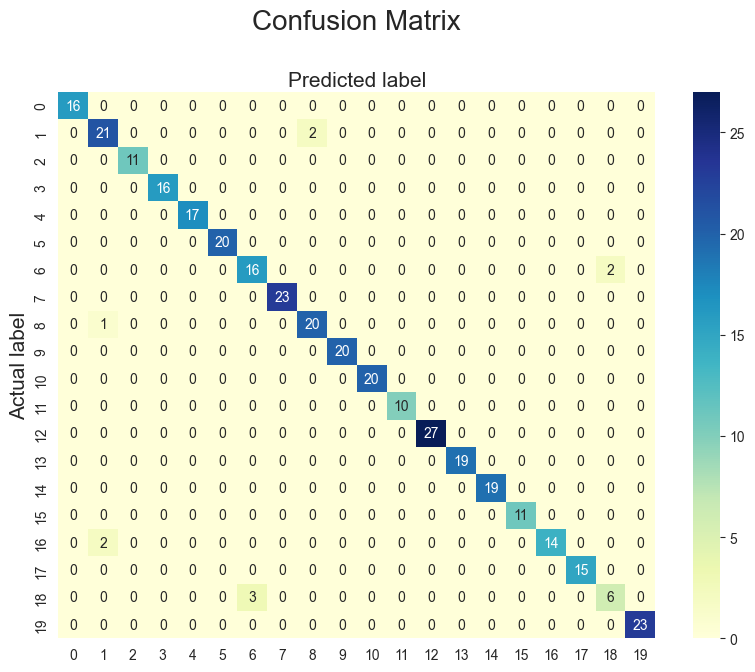

              precision    recall  f1-score   support

      banana       1.00      1.00      1.00        16
   blackgram       0.88      0.91      0.89        23
    chickpea       1.00      1.00      1.00        11
     coconut       1.00      1.00      1.00        16
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        20
        jute       0.84      0.89      0.86        18
 kidneybeans       1.00      1.00      1.00        23
      lentil       0.91      0.95      0.93        21
       maize       1.00      1.00      1.00        20
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      1.00      1.00        10
    mungbean       1.00      1.00      1.00        27
   muskmelon       1.00      1.00      1.00        19
      orange       1.00      1.00      1.00        19
      papaya       1.00      1.00      1.00        11
  pigeonpeas       1.00      0.88      0.93        16
 pomegranate       1.00    

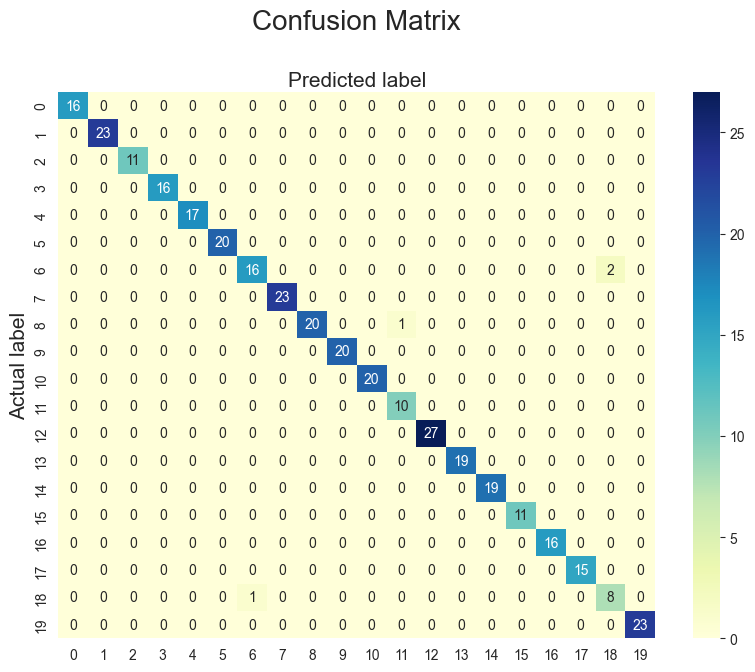

              precision    recall  f1-score   support

      banana       1.00      1.00      1.00        16
   blackgram       1.00      1.00      1.00        23
    chickpea       1.00      1.00      1.00        11
     coconut       1.00      1.00      1.00        16
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        20
        jute       0.94      0.89      0.91        18
 kidneybeans       1.00      1.00      1.00        23
      lentil       1.00      0.95      0.98        21
       maize       1.00      1.00      1.00        20
       mango       1.00      1.00      1.00        20
   mothbeans       0.91      1.00      0.95        10
    mungbean       1.00      1.00      1.00        27
   muskmelon       1.00      1.00      1.00        19
      orange       1.00      1.00      1.00        19
      papaya       1.00      1.00      1.00        11
  pigeonpeas       1.00      1.00      1.00        16
 pomegranate       1.00    

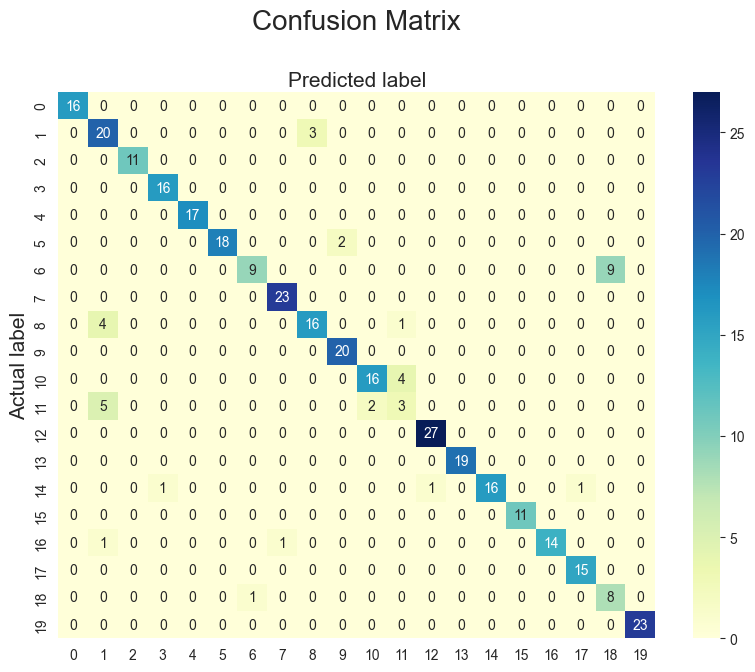

              precision    recall  f1-score   support

      banana       1.00      1.00      1.00        16
   blackgram       0.67      0.87      0.75        23
    chickpea       1.00      1.00      1.00        11
     coconut       0.94      1.00      0.97        16
      coffee       1.00      1.00      1.00        17
      cotton       1.00      0.90      0.95        20
        jute       0.90      0.50      0.64        18
 kidneybeans       0.96      1.00      0.98        23
      lentil       0.84      0.76      0.80        21
       maize       0.91      1.00      0.95        20
       mango       0.89      0.80      0.84        20
   mothbeans       0.38      0.30      0.33        10
    mungbean       0.96      1.00      0.98        27
   muskmelon       1.00      1.00      1.00        19
      orange       1.00      0.84      0.91        19
      papaya       1.00      1.00      1.00        11
  pigeonpeas       1.00      0.88      0.93        16
 pomegranate       0.94    

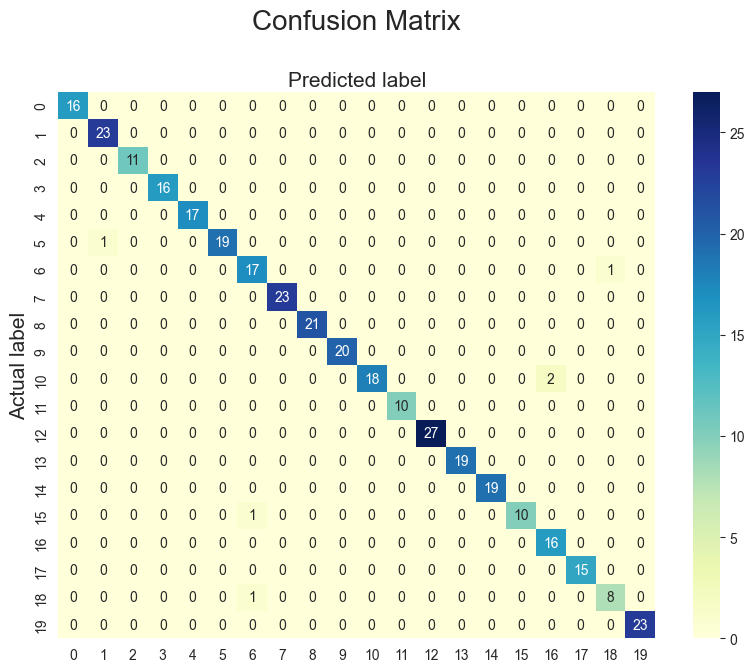

              precision    recall  f1-score   support

      banana       1.00      1.00      1.00        16
   blackgram       0.96      1.00      0.98        23
    chickpea       1.00      1.00      1.00        11
     coconut       1.00      1.00      1.00        16
      coffee       1.00      1.00      1.00        17
      cotton       1.00      0.95      0.97        20
        jute       0.89      0.94      0.92        18
 kidneybeans       1.00      1.00      1.00        23
      lentil       1.00      1.00      1.00        21
       maize       1.00      1.00      1.00        20
       mango       1.00      0.90      0.95        20
   mothbeans       1.00      1.00      1.00        10
    mungbean       1.00      1.00      1.00        27
   muskmelon       1.00      1.00      1.00        19
      orange       1.00      1.00      1.00        19
      papaya       1.00      0.91      0.95        11
  pigeonpeas       0.89      1.00      0.94        16
 pomegranate       1.00    

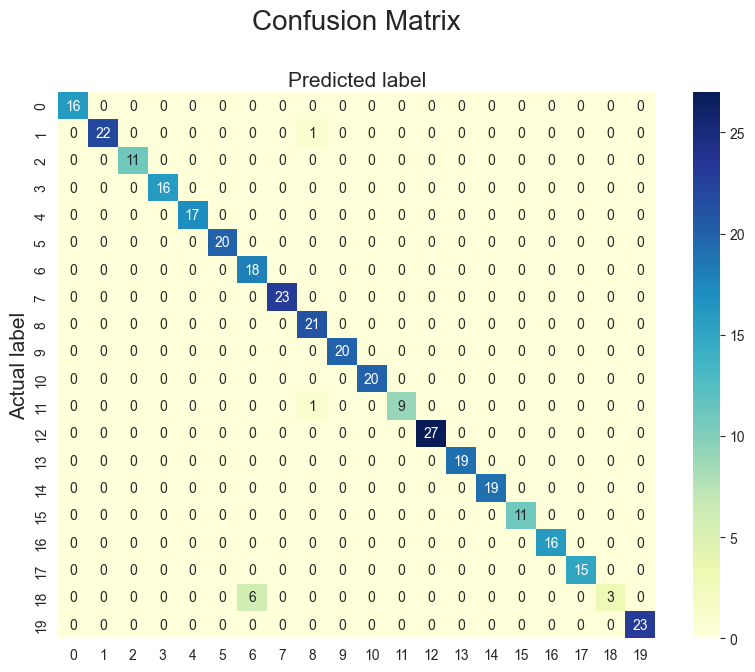

              precision    recall  f1-score   support

      banana       1.00      1.00      1.00        16
   blackgram       1.00      0.96      0.98        23
    chickpea       1.00      1.00      1.00        11
     coconut       1.00      1.00      1.00        16
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        20
        jute       0.75      1.00      0.86        18
 kidneybeans       1.00      1.00      1.00        23
      lentil       0.91      1.00      0.95        21
       maize       1.00      1.00      1.00        20
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      0.90      0.95        10
    mungbean       1.00      1.00      1.00        27
   muskmelon       1.00      1.00      1.00        19
      orange       1.00      1.00      1.00        19
      papaya       1.00      1.00      1.00        11
  pigeonpeas       1.00      1.00      1.00        16
 pomegranate       1.00    

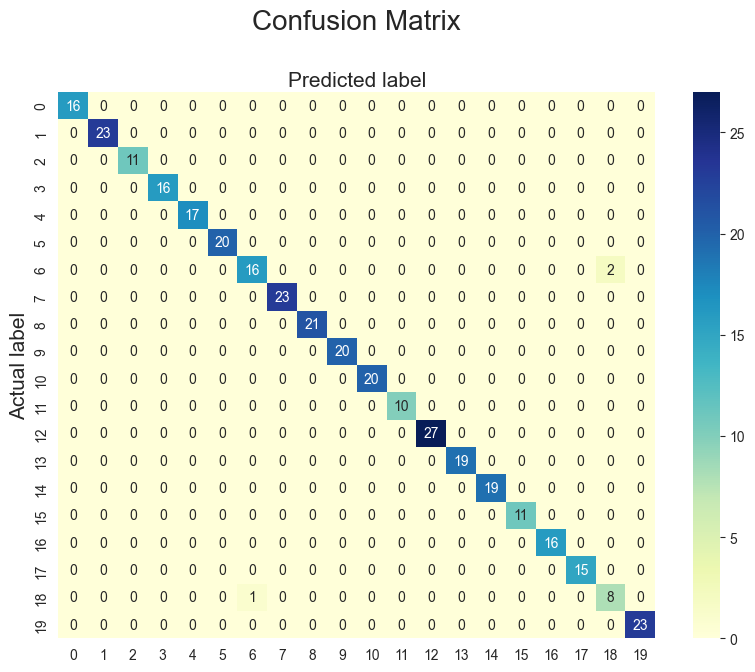

              precision    recall  f1-score   support

      banana       1.00      1.00      1.00        16
   blackgram       1.00      1.00      1.00        23
    chickpea       1.00      1.00      1.00        11
     coconut       1.00      1.00      1.00        16
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        20
        jute       0.94      0.89      0.91        18
 kidneybeans       1.00      1.00      1.00        23
      lentil       1.00      1.00      1.00        21
       maize       1.00      1.00      1.00        20
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      1.00      1.00        10
    mungbean       1.00      1.00      1.00        27
   muskmelon       1.00      1.00      1.00        19
      orange       1.00      1.00      1.00        19
      papaya       1.00      1.00      1.00        11
  pigeonpeas       1.00      1.00      1.00        16
 pomegranate       1.00    

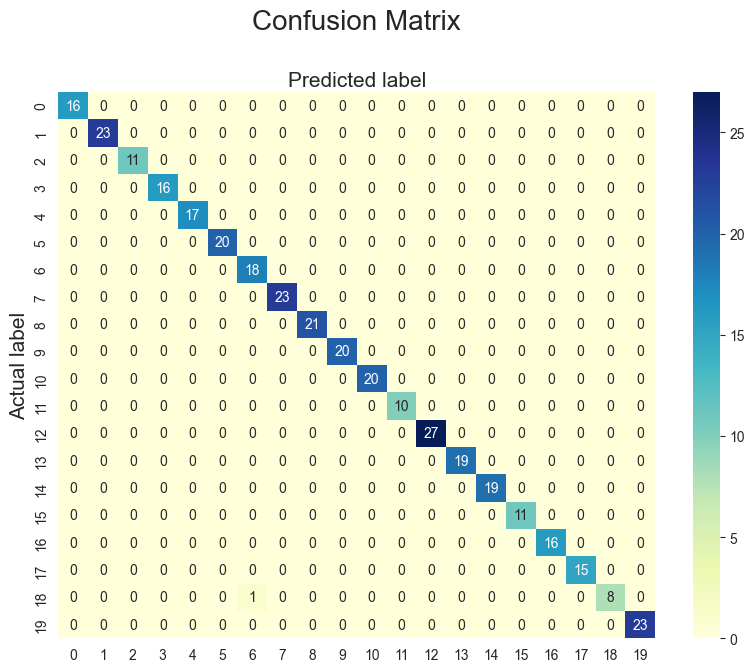

              precision    recall  f1-score   support

      banana       1.00      1.00      1.00        16
   blackgram       1.00      1.00      1.00        23
    chickpea       1.00      1.00      1.00        11
     coconut       1.00      1.00      1.00        16
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        20
        jute       0.95      1.00      0.97        18
 kidneybeans       1.00      1.00      1.00        23
      lentil       1.00      1.00      1.00        21
       maize       1.00      1.00      1.00        20
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      1.00      1.00        10
    mungbean       1.00      1.00      1.00        27
   muskmelon       1.00      1.00      1.00        19
      orange       1.00      1.00      1.00        19
      papaya       1.00      1.00      1.00        11
  pigeonpeas       1.00      1.00      1.00        16
 pomegranate       1.00    

In [16]:


# Spot-Check Models (New Models)
def GetModel():
    Models = []
    Models.append(('GBM', GradientBoostingClassifier()))
    Models.append(('CatBoost', CatBoostClassifier(silent=True)))
    Models.append(('LDA', LinearDiscriminantAnalysis()))
    Models.append(('QDA', QuadraticDiscriminantAnalysis()))
    Models.append(('NC', NearestCentroid()))
    Models.append(('DecisionTree', DecisionTreeClassifier()))
    Models.append(('SVM', SVC()))
    Models.append(('NaiveBayes', GaussianNB()))
    Models.append(('RandomForest', RandomForestClassifier()))
    return Models

# Performance Measure
def classification_metrics(model, conf_matrix, X_train, y_train, X_test, y_test, y_pred):
    print(f"Training Accuracy Score: {model.score(X_train, y_train) * 100:.1f}%")
    print(f"Validation Accuracy Score: {model.score(X_test, y_test) * 100:.1f}%")
    
    # Calculate precision, recall, and f1 score
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")

    # Plotting confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(conf_matrix), annot=True, cmap='YlGnBu', fmt='g')
    ax.xaxis.set_label_position('top')
    plt.tight_layout()
    plt.title('Confusion Matrix', fontsize=20, y=1.1)
    plt.ylabel('Actual label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    plt.show()
    
    # Print classification report
    print(classification_report(y_test, y_pred))

# Save Trained Model
def save_model(model, filename):
    pickle.dump(model, open(filename, 'wb'))

# Train and evaluate all models
models = GetModel()

for name, model in models:
    print(f"\nTraining and Evaluating Model: {name}")
    pipeline = make_pipeline(StandardScaler(), model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Evaluate performance
    classification_metrics(pipeline, conf_matrix, X_train, y_train, X_test, y_test, y_pred)
    
    # Save each model
    save_model(pipeline, f'new_model/{name}_model.pkl')


PREDICTION SYSTEM

In [17]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler

# Load saved model
def load_model(filename):
    return pickle.load(open(filename, 'rb'))

# Preprocess input data
def preprocess_input(input_data, scaler=None):
    # Convert the input into a DataFrame
    input_df = pd.DataFrame([input_data])
    
    # Apply scaler if provided (StandardScaler in this case)
    if scaler:
        input_df = scaler.transform(input_df)
    
    return input_df

# Predict output
def predict_output(input_data, model_filename):
    # Load the saved model
    model = load_model(model_filename)
    
    # Check if the model pipeline has a scaler
    if hasattr(model, 'named_steps') and 'scaler' in model.named_steps:
        scaler = model.named_steps['scaler']
        input_df = preprocess_input(input_data, scaler=scaler)
    else:
        input_df = preprocess_input(input_data)
    
    # Generate prediction
    prediction = model.predict(input_df)
    
    return prediction

# Example input data (Make sure it matches your dataset's feature format)
# This should be a list of values for the input row corresponding to the features
#107	34	32	26.774637	66.413269	6.780064	177.774507	coffee
input_data = {
    'N': 107,        # Example value for Nitrogen
    'P': 34,         # Example value for Phosphorous
    'K': 32,          # Example value for Potassium
    'temperature': 26,# Example temperature
    'humidity': 66,  # Example humidity
    'ph': 6.7,        # Example pH value
    'rainfall': 177  # Example rainfall
}

# Path to the saved model (change this to the appropriate model file, e.g., 'CatBoost_model.pkl')
# model_filename = 'new_model\CatBoost_model.pkl'
model_filename = 'new_model\RandomForest_model.pkl'

# Generate prediction
prediction = predict_output(input_data, model_filename)
print(f"Predicted crop: {prediction[0]}")


Predicted crop: coffee


In [19]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler

# Load saved model
def load_model(filename):
    return pickle.load(open(filename, 'rb'))

# Preprocess input data
def preprocess_input(input_data, scaler=None):
    # Convert the input into a DataFrame
    input_df = pd.DataFrame([input_data])
    
    # Apply scaler if provided (StandardScaler in this case)
    if scaler:
        input_df = scaler.transform(input_df)
    
    return input_df

# Predict output
def predict_output(input_data, model_filename):
    # Load the saved model
    model = load_model(model_filename)
    
    # Check if the model pipeline has a scaler
    if hasattr(model, 'named_steps') and 'scaler' in model.named_steps:
        scaler = model.named_steps['scaler']
        input_df = preprocess_input(input_data, scaler=scaler)
    else:
        input_df = preprocess_input(input_data)
    
    # Generate prediction
    prediction = model.predict(input_df)
    
    return prediction

# Example input data (Make sure it matches your dataset's feature format)
# This should be a list of values for the input row corresponding to the features
#78	42	42	20.130175	81.604873	7.628473	262.717340	rice
input_data = {
    'N': 78,        # Example value for Nitrogen
    'P': 42,         # Example value for Phosphorous
    'K': 42,          # Example value for Potassium
    'temperature': 20,# Example temperature
    'humidity': 81,  # Example humidity
    'ph': 7.6,        # Example pH value
    'rainfall': 262  # Example rainfall
}

# Path to the saved model (change this to the appropriate model file, e.g., 'CatBoost_model.pkl')
# model_filename = 'new_model/CatBoost_model.pkl'
model_filename = 'new_model\RandomForest_model.pkl'

# Generate prediction
prediction = predict_output(input_data, model_filename)
print(f"Predicted crop: {prediction[0]}")


Predicted crop: rice
